# Set up

Python librairies imports :

In [1]:
# File system management
import os
import pickle
import dill

from collections import Counter

# Data manipulation
import numpy as np
import pandas as pd

# Scikit-learn
from sklearn.model_selection import cross_val_predict, cross_validate, cross_val_score, train_test_split
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_curve, roc_auc_score, f1_score, accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import make_scorer
from sklearn.preprocessing import StandardScaler 

# Hyperparameters optimisation
from hyperopt import tpe, hp, fmin, space_eval, STATUS_OK, Trials, SparkTrials 
from hyperopt.pyll.base import scope

# XGBoost
import xgboost as xgb

# LightGBM
import lightgbm as ltb

# Balancing data
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Interpratability
from lime import lime_tabular

# Data drift
from evidently.report import Report
from evidently.metric_preset import DataDriftPreset

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_theme(palette="Set1")

Define work location :

In [2]:
project_path = "/Users/victor/Documents/OPENCLASSROOMS/projet_7"

# Change directory
os.chdir(project_path)

Load data :

In [3]:
# Load data
data = pd.read_csv("data/processed/train_feature_engineering.csv", index_col=[0])

# Functions

In [4]:
# Function to display confusion matrix
def display_confusion_matrix(y_test, y_pred, model_name="Model"):
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.title(model_name + ": Confusion matrix")
    plt.grid(visible=None)
    plt.show()

In [5]:
# Function to compute roc curve
def compute_roc_curve(y_test, y_pred_proba, model_name="Model", disp_best_th=False):
    # Compute metrics
    fpr, tpr, thresholds = roc_curve(y_test,  y_pred_proba)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Create fig
    plt.figure()
    plt.title(model_name + ": ROC curve")

    # Display x=y
    sns.lineplot(x=[0, 1], y=[0, 1], linestyle='--')

    # Display ROC curve
    sns.lineplot(x=fpr, y=tpr, legend='brief', label="AUC = {:.3f}".format((auc)))

    if disp_best_th is True:
        # Compute best threshold
        o_tpr = tpr[np.argmin(np.abs(fpr+tpr-1))]
        o_fpr = fpr[np.argmin(np.abs(fpr+tpr-1))]
        o_threshold = thresholds[np.argmin(np.abs(fpr+tpr-1))]

        # Display best threshold
        sns.scatterplot(x=[o_fpr], y=[o_tpr], legend='brief', label="Best threshold = {:.3f}".format(o_threshold))

    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.legend(loc=4)
    plt.show()

    # Return AUC score
    return auc

In [6]:
# Return the best model from hyperopt trials
def trials_best_model(trials):
    valid_trial_list = [trial for trial in trials
                            if STATUS_OK == trial['result']['status']]
    losses = [float(trial['result']['loss']) for trial in valid_trial_list]
    min_loss_idx = np.argmin(losses)
    best_trial_obj = valid_trial_list[min_loss_idx]
    print("Best result :", best_trial_obj['result']['loss'])
    return best_trial_obj['result']['model']

# MLFlow

Set up of MLFlow tracking.

In [7]:
import mlflow
from mlflow import log_metric, log_param, log_artifacts

# Create experiment
experiment_name = 'credit_scoring'
mlflow.set_experiment(experiment_name)
mlflow.end_run()

In [8]:
# Function to log model to mlflow
def log_mlflow(model, name, custom_score, n_estimator=None, max_depth=None, auc_score=None, f1_score=None, acc_score=None,
               train_class_0=None, train_class_1=None):

    # Track params and metrics 
    with mlflow.start_run():
        # Set run name
        mlflow.set_tag("mlflow.runName", name)

        # Set parameters
        mlflow.log_param("n_estimators", n_estimator)
        mlflow.log_param("max_depth", max_depth)
        mlflow.log_param("train_class_0", train_class_0)
        mlflow.log_param("train_class_1", train_class_1)

        # Set metrics
        mlflow.log_metric("Custom score", custom_score)
        mlflow.log_metric("AUC", auc_score)
        mlflow.log_metric("F1", f1_score)
        mlflow.log_metric("Accuracy", acc_score)

        # Save model to artifacts
        mlflow.sklearn.log_model(model, name)

    mlflow.end_run()

# Data preparation

In [9]:
# Define target and features
TARGET = 'TARGET'
target = data[TARGET].to_numpy()
features = data.drop(columns=TARGET).to_numpy()
features_names = data.drop(columns=TARGET).columns.to_list()

# Define training set size
TRAIN_SIZE = 0.8

# Define random state
RANDOM_STATE = 42

## Missing values

In [10]:
# Check missing values
nan_values = data.isna().sum().sum()
print("Missing values = {} ({:.2%})".format(nan_values, nan_values/data.size))

Missing values = 37539165 (20.11%)


Fill missing values with simple imputer.

In [11]:
# Create imputer
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fit to data
imp_mean.fit(features)

# Transform data
features_fill = imp_mean.transform(features)

@todo: display diff distribution filled an not filled?

## Scaling data

@TODO: scaledata ? without encoded columns

## Split data

Split the data into training and testing sets.

In [12]:
# Split dataset (filled)
x_train, x_test, y_train, y_test = train_test_split(features_fill, target, train_size=TRAIN_SIZE, random_state=RANDOM_STATE)

In [13]:
# Define stratifiedKfold
strat_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

## Balance data

In [14]:
y_train_counter = Counter(y_train)
print("Training target statistics:", y_train_counter)
print("Testing target statistics:", Counter(y_test))

# Print ratio
print("Ratio is 1:{:.0f}".format(y_train_counter[0] / y_train_counter[1]))

Training target statistics: Counter({0.0: 226201, 1.0: 19804})
Testing target statistics: Counter({0.0: 56481, 1.0: 5021})
Ratio is 1:11


I will define a pipeline that first transforms the training dataset with SMOTE then fits the model.

In [15]:
# Define oversampling and undersampling
over = SMOTE(sampling_strategy=0.5) # oversample to 1:2 ratio 
under = RandomUnderSampler(sampling_strategy=1) # undersample to 1:1 ratio

# Define pipeline
steps = [('over', over), ('under', under)]
# steps = [('over', over)]
pipeline = Pipeline(steps=steps)

# Transform the dataset
x_res, y_res = pipeline.fit_resample(x_train, y_train)

print("Training target statistics:", Counter(y_res))
print("Testing target statistics:", Counter(y_test))

Training target statistics: Counter({0.0: 113100, 1.0: 113100})
Testing target statistics: Counter({0.0: 56481, 1.0: 5021})


# Customization

In [16]:
# Define threshold
THRESHOLD_CLASS0 = 0.7  # belong to class 0 (repay success)
THRESHOLD_CLASS1 = 1 - THRESHOLD_CLASS0  # belong to class 1 (repay failure)

@TODO : justifier choix

## Custom loss function

Rule : cost FN (dont repay - predicted as repay) = 10 cost FP (repay - predicted as dont repay)

In [17]:
# Custom loss function based on business rule
def business_loss_func(y_true, y_pred):
    tp, fp, fn, tn = confusion_matrix(y_true, y_pred).ravel()
    cost = (fp + (10 * fn)) / len(y_true)
    return float(cost)

In [18]:
# # Custom loss function for xgboost
# def xgb_custom_loss_func(y_true, y_pred):
#     tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
#     fnr = fn / (fn + tp)  # false negative rate
#     fpr = fp / (fp + tn)  # false positive rate
#     cost = float((10 * fnr) + fpr)
    
#     grad = np.repeat(2 * cost, len(y_pred))
#     hess = np.repeat(2, len(y_pred))

#     return grad, hess

In [19]:
# # Custom loss function for lightgbm
# def lgbm_custom_loss_func(y_true, y_pred):
#     tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
#     fnr = fn / (fn + tp)  # false negative rate
#     fpr = fp / (fp + tn)  # false positive rate
#     cost = float((10 * fnr) + fpr)
    
#     grad = 2 * cost
#     hess = 2

#     return grad, hess

I create custom scorer with the business rule.

In [20]:
# Create business score
business_score = make_scorer(business_loss_func, greater_is_better=False)

# Classification

In [21]:
# Function to compute predictions and metrics
def compute_classification_results(model, model_name, x_test, y_test):

    # Predict probability of class 1 (repay failure)
    y_pred_proba = model.predict_proba(x_test)[:,1]

    # Predict values 
    y_pred = model.predict(x_test)

    # Display confusion matrix
    display_confusion_matrix(y_test, y_pred, model_name=model_name)

    # Draw roc curve
    auc_score = compute_roc_curve(y_test, y_pred_proba, model_name=model_name)

    # Compute scores
    clf_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict=True)).transpose()
    display(clf_report)

    # Display business loss func
    business_score = business_loss_func(y_test, y_pred)
    print("Business score =", business_score)

    return business_score, auc_score, clf_report

# DummyClassifier

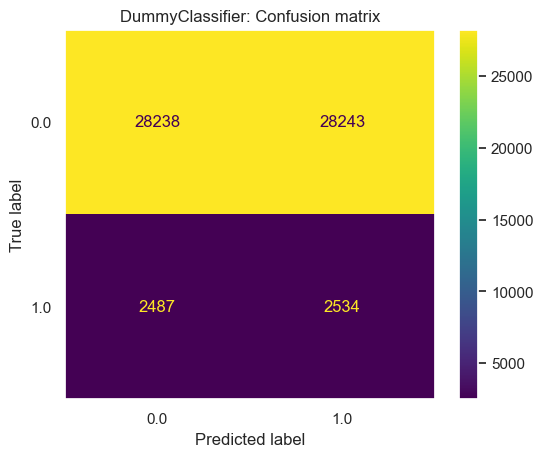

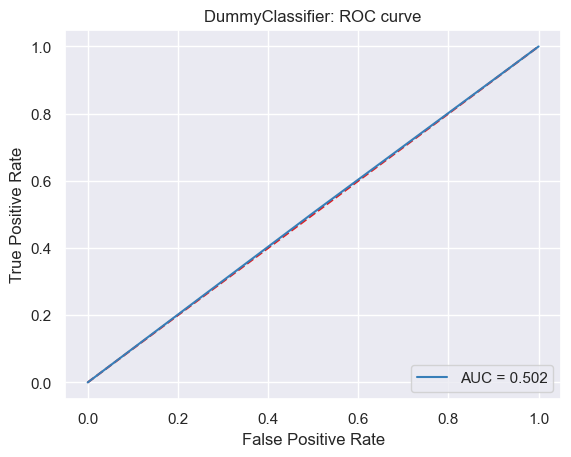

,precision,recall,f1-score,support
0.0,0.919056,0.499956,0.647616,56481.000000
1.0,0.082334,0.504680,0.141572,5021.000000
accuracy,0.500341,0.500341,0.500341,0.500341
macro avg,0.500695,0.502318,0.394594,61502.000000
weighted avg,0.850746,0.500341,0.606303,61502.000000


Business score = 0.8635979317745764


/Users/victor/miniconda3/envs/oc_p7/lib/python3.10/site-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


In [22]:
# Create logistic regression model
dc = DummyClassifier(strategy='stratified', random_state=RANDOM_STATE)
dc_name = 'DummyClassifier'

# Fit model
dc.fit(x_res, y_res)

# Compute results
dc_business_score, dc_auc, dc_report = compute_classification_results(dc, dc_name, x_test, y_test)

# Save logs
log_mlflow(dc, dc_name, auc_score=dc_auc, custom_score=dc_business_score,
           f1_score=dc_report.loc['weighted avg', 'f1-score'], 
           acc_score=dc_report.loc['accuracy', 'precision'],
           train_class_0=Counter(y_res)[0], train_class_1=Counter(y_res)[1])

# LogisticRegression

/Users/victor/miniconda3/envs/oc_p7/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


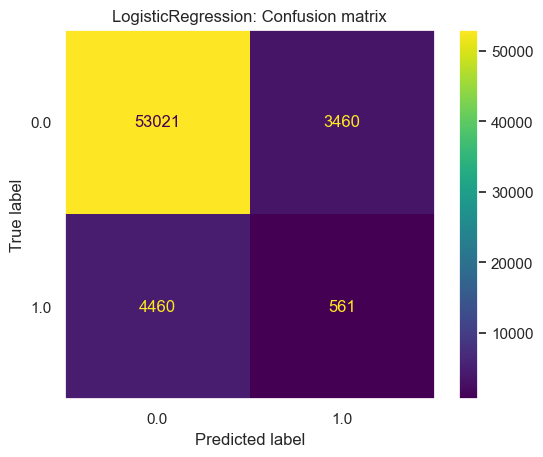

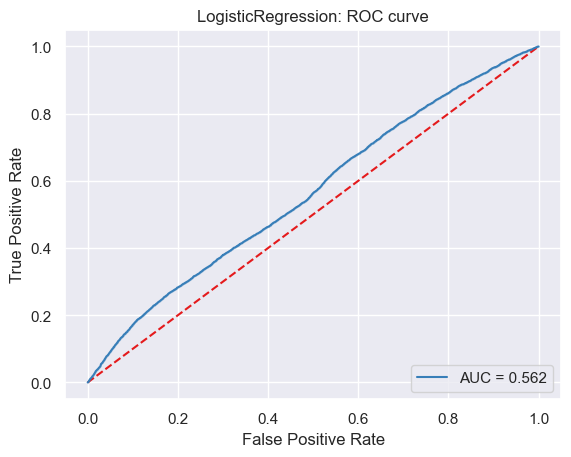

,precision,recall,f1-score,support
0.0,0.922409,0.938740,0.930503,56481.000000
1.0,0.139518,0.111731,0.124088,5021.000000
accuracy,0.871224,0.871224,0.871224,0.871224
macro avg,0.530963,0.525236,0.527295,61502.000000
weighted avg,0.858494,0.871224,0.864668,61502.000000


Business score = 0.7814380020161946
CPU times: user 2min 12s, sys: 1.71 s, total: 2min 14s
Wall time: 1min 4s


In [23]:
%%time

# Create logistic regression model
lr = LogisticRegression(random_state=RANDOM_STATE)
lr_name = 'LogisticRegression'

# Train model
lr.fit(x_res, y_res)

# Compute results
lr_business_score, lr_auc, lr_report = compute_classification_results(lr, lr_name, x_test, y_test)

# Save logs
log_mlflow(lr, lr_name, auc_score=lr_auc, custom_score=lr_business_score,
           f1_score=lr_report.loc['weighted avg', 'f1-score'], 
           acc_score=lr_report.loc['accuracy', 'precision'],
           train_class_0=Counter(y_res)[0], train_class_1=Counter(y_res)[1])

# RandomForest

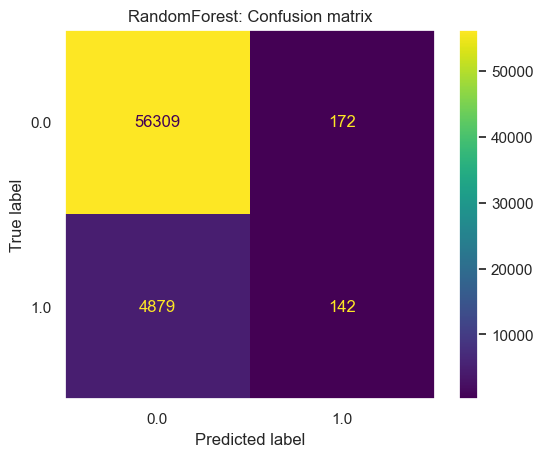

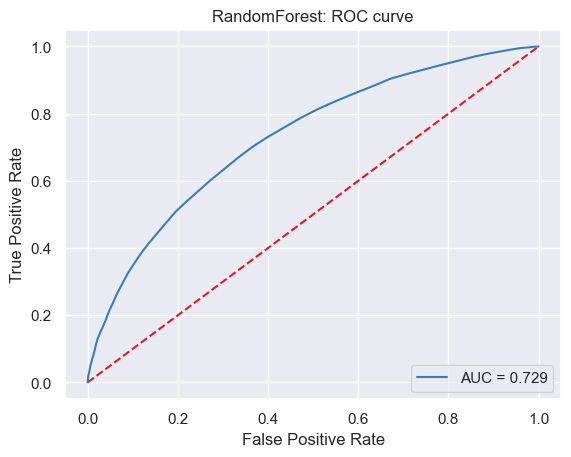

,precision,recall,f1-score,support
0.0,0.920262,0.996955,0.957075,56481.000000
1.0,0.452229,0.028281,0.053233,5021.000000
accuracy,0.917873,0.917873,0.917873,0.917873
macro avg,0.686246,0.512618,0.505154,61502.000000
weighted avg,0.882052,0.917873,0.883285,61502.000000


Business score = 0.7961041917336021
CPU times: user 3min 48s, sys: 3.2 s, total: 3min 52s
Wall time: 3min 56s


In [24]:
%%time

# Create random forest classifier
rf = RandomForestClassifier(random_state=RANDOM_STATE)
rf_name = 'RandomForest'

# Train model
rf.fit(x_res, y_res)

# Compute results
rf_business_score, rf_auc, rf_report = compute_classification_results(rf, rf_name, x_test, y_test)

# Save logs
rf_params = rf.get_params()
log_mlflow(rf, rf_name,
           custom_score=rf_business_score,
           auc_score=rf_auc,
           f1_score=rf_report.loc['weighted avg', 'f1-score'], 
           acc_score=rf_report.loc['accuracy', 'precision'],
           n_estimator=rf_params['n_estimators'],
           max_depth=rf_params['max_depth'], 
           train_class_0=Counter(y_res)[0],
           train_class_1=Counter(y_res)[1])

# XGBoost

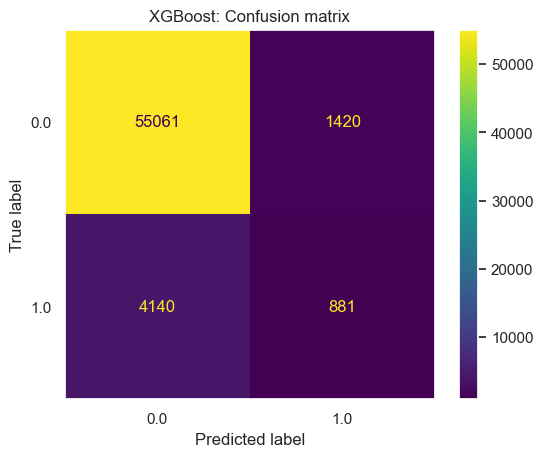

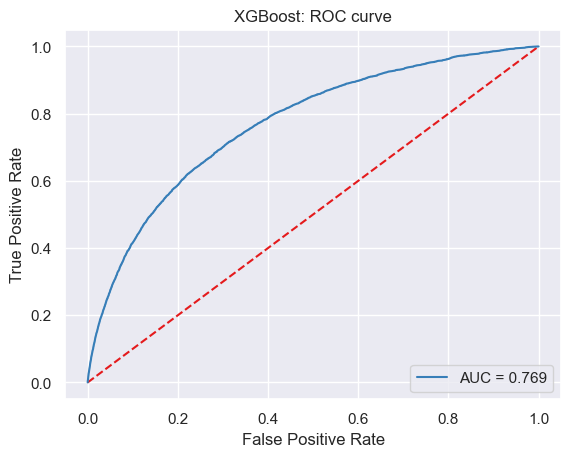

,precision,recall,f1-score,support
0.0,0.930069,0.974859,0.951937,56481.000000
1.0,0.382877,0.175463,0.240645,5021.000000
accuracy,0.909596,0.909596,0.909596,0.909596
macro avg,0.656473,0.575161,0.596291,61502.000000
weighted avg,0.885396,0.909596,0.893868,61502.000000


Business score = 0.6962375207310332
CPU times: user 29min 15s, sys: 3min 5s, total: 32min 21s
Wall time: 5min 50s


In [25]:
%%time

# Create XGBoost classifier
xgbc = xgb.XGBClassifier(random_state=RANDOM_STATE)
xgbc_name = 'XGBoost'

# Train model
xgbc.fit(x_res, y_res)

# Compute results
xgbc_business_score, xgbc_auc, xgbc_report = compute_classification_results(xgbc, xgbc_name, x_test, y_test)

# Save logs
xgbc_params = xgbc.get_params()
log_mlflow(xgbc, xgbc_name,
           custom_score=xgbc_business_score,
           auc_score=xgbc_auc,
           f1_score=xgbc_report.loc['weighted avg', 'f1-score'], 
           acc_score=xgbc_report.loc['accuracy', 'precision'],
           n_estimator=xgbc_params['n_estimators'],
           max_depth=xgbc_params['max_depth'], 
           train_class_0=Counter(y_res)[0],
           train_class_1=Counter(y_res)[1])

# LightGBM

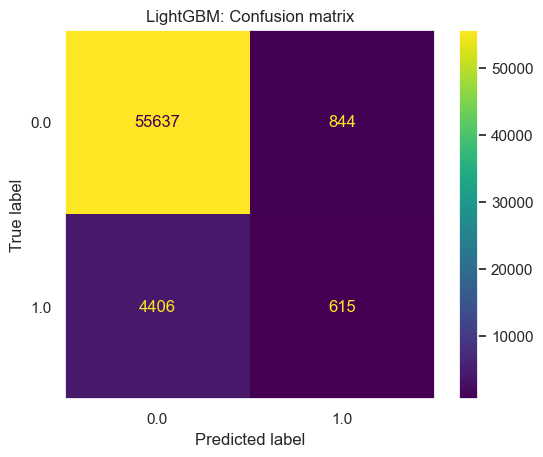

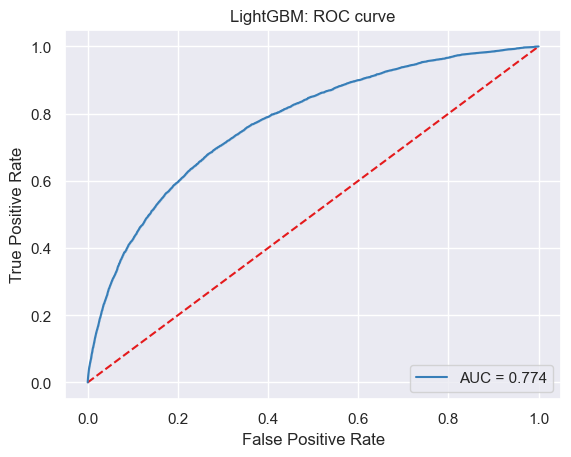

,precision,recall,f1-score,support
0.0,0.926619,0.985057,0.954945,56481.000000
1.0,0.421522,0.122486,0.189815,5021.000000
accuracy,0.914637,0.914637,0.914637,0.914637
macro avg,0.674070,0.553771,0.572380,61502.000000
weighted avg,0.885383,0.914637,0.892480,61502.000000


Business score = 0.7301225976391011
CPU times: user 2min 1s, sys: 4.65 s, total: 2min 6s
Wall time: 1min 1s


In [26]:
%%time

# Create LightGBM classifier
lgbm = ltb.LGBMClassifier(random_state=RANDOM_STATE)
lgbm_name = 'LightGBM'

# Train model
lgbm.fit(x_res, y_res)

# Compute results
lgbm_business_score, lgbm_auc, lgbm_report = compute_classification_results(lgbm, lgbm_name, x_test, y_test)

# Save logs
lgbm_params = lgbm.get_params()
log_mlflow(lgbm, lgbm_name,
           custom_score=lgbm_business_score,
           auc_score=lgbm_auc,
           f1_score=lgbm_report.loc['weighted avg', 'f1-score'], 
           acc_score=lgbm_report.loc['accuracy', 'precision'],
           n_estimator=lgbm_params['n_estimators'],
           max_depth=lgbm_params['max_depth'], 
           train_class_0=Counter(y_res)[0],
           train_class_1=Counter(y_res)[1])

# Comparison

In [27]:
# Create results dataframe
res_df = pd.DataFrame({
    'Model':['Dummy', 'LogisticRegression', 'RandomForest', 'XGBoost', 'LightGBM'],
    'Business score': [dc_business_score, lr_business_score, rf_business_score, xgbc_business_score, lgbm_business_score],
    'Accuracy score': [dc_report.loc['accuracy', 'precision'],
                       lr_report.loc['accuracy', 'precision'],
                       rf_report.loc['accuracy', 'precision'],
                       xgbc_report.loc['accuracy', 'precision'],
                       lgbm_report.loc['accuracy', 'precision']],
    'AUC score': [dc_auc, lr_auc, rf_auc, xgbc_auc, lgbm_auc],
})

display(res_df)

,Model,Business score,Accuracy score,AUC score
0,Dummy,0.863598,0.500341,0.502318
1,LogisticRegression,0.781438,0.871224,0.562259
2,RandomForest,0.796104,0.917873,0.729229
3,XGBoost,0.696238,0.909596,0.769476
4,LightGBM,0.730123,0.914637,0.774008


The best models are XGBoost and LightGBM.

Let's try to tune the hyperparameters of these two models.

# Hyperparametrization

XGBoost tuning

{'colsample_bytree': 0.5, 'learning_rate': 0.9, 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 400, 'subsample': 0.5153537923016334}
{'colsample_bytree': 1.0, 'learning_rate': 0.7000000000000001, 'max_depth': 6, 'min_child_weight': 6, 'n_estimators': 450, 'subsample': 0.6845865262832355}
{'colsample_bytree': 0.5, 'learning_rate': 0.9, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 350, 'subsample': 0.7141954545929138}
{'colsample_bytree': 1.0, 'learning_rate': 0.9, 'max_depth': 8, 'min_child_weight': 4, 'n_estimators': 100, 'subsample': 0.7984294100219231}
{'colsample_bytree': 1.0, 'learning_rate': 1.0, 'max_depth': 8, 'min_child_weight': 8, 'n_estimators': 300, 'subsample': 0.5213640449108949}
{'colsample_bytree': 0.5, 'learning_rate': 0.5, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.9880693630431192}
{'colsample_bytree': 0.5, 'learning_rate': 0.4, 'max_depth': 16, 'min_child_weight': 2, 'n_estimators': 200, 'subsample': 0.817662375055288

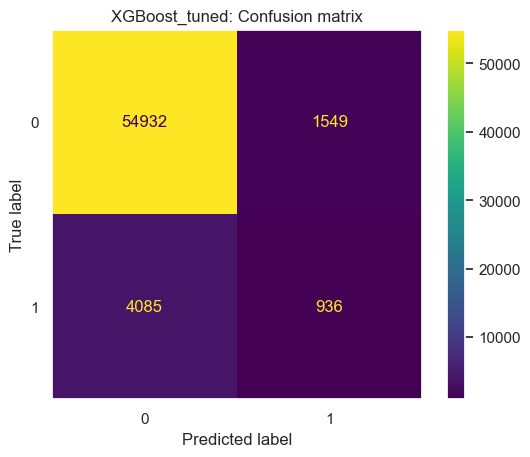

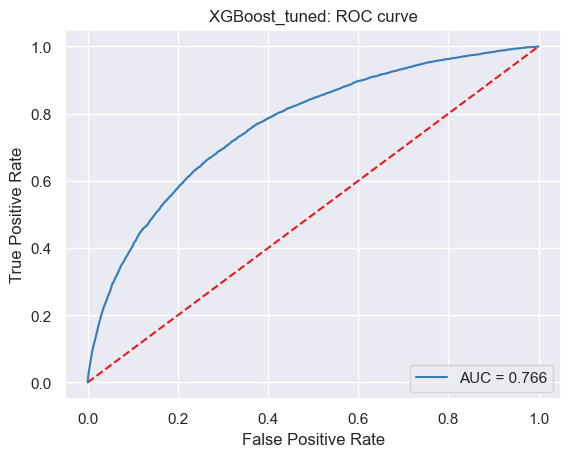

,precision,recall,f1-score,support
0,0.930783,0.972575,0.951220,56481.000000
1,0.376660,0.186417,0.249400,5021.000000
accuracy,0.908393,0.908393,0.908393,0.908393
macro avg,0.653721,0.579496,0.600310,61502.000000
weighted avg,0.885544,0.908393,0.893924,61502.000000


Business score = 0.6893922148873207
CPU times: user 1d 14h 30min 41s, sys: 2h 20min 26s, total: 1d 16h 51min 8s
Wall time: 6h 3s


In [55]:
%%time

# Create XGBoost classifier for tuning
xgbt = xgb.XGBClassifier(random_state=RANDOM_STATE)
xgbt_name = 'XGBoost_tuned'

# Possible values of hyperparameters
xgbt_space = {'max_depth':  scope.int(hp.quniform("max_depth", 3, 18, 1)),
              'subsample':  hp.uniform('subsample', 0.5, 1.),
              'colsample_bytree': hp.quniform('colsample_bytree', 0.5, 1, 0.5),
              'learning_rate': hp.quniform('learning_rate', 0.1, 1, 0.1),
              'min_child_weight' : scope.int(hp.quniform('min_child_weight', 0, 10, 1)),
              'n_estimators': scope.int(hp.quniform('n_estimators', 50, 500, 50))}

# define objective function
def xgbt_tuning(params):
    print(params)
    xgbt.set_params(**params)
    score = cross_val_score(xgbt, x_res, y_res, scoring=business_score).mean()
    return {"loss": -score, "status": STATUS_OK, "model":xgbt}

# Initialize trials object
xgbt_trials = Trials()

# Find best model
xgbt_best = fmin(fn=xgbt_tuning, space=xgbt_space, algo=tpe.suggest, max_evals=10, trials=xgbt_trials)
xgbt_best_model = trials_best_model(xgbt_trials)
print(xgbt_best_model)

# Train model
xgbt_best_model.fit(x_res, y_res)

# Compute results
xgbt_business_score, xgbt_auc, xgbt_report = compute_classification_results(xgbt_best_model, xgbt_name, x_test, y_test)

# Save logs
xgbt_params = xgbt.get_params()
log_mlflow(xgbt_best_model, xgbt_name,
           custom_score=xgbt_business_score,
           auc_score=xgbt_auc,
           f1_score=xgbt_report.loc['weighted avg', 'f1-score'], 
           acc_score=xgbt_report.loc['accuracy', 'precision'],
           n_estimator=xgbt_params['n_estimators'],
           max_depth=xgbt_params['max_depth'], 
           train_class_0=Counter(y_res)[0],
           train_class_1=Counter(y_res)[1])

The tuned model is slightly better than the standard xgboost.

In [75]:
xgb_score_imp = (xgbc_business_score - xgbt_business_score) / xgbc_business_score
print("The XGBoost model improved the business score by {:.1%}".format(xgb_score_imp))

The XGBoost model improved the business score by 1.1%


# Explainer

In [28]:
# # Create lime explainer
explainer = lime_tabular.LimeTabularExplainer(x_res, mode="classification",
                                              class_names=['REPAY SUCCESS', 'REPAY FAILURE'],
                                              feature_names=features_names)

In [56]:
idx = 1001

print("Prediction : ", xgbc.predict(x_test)[idx])
print("Actual :     ", y_test[idx])

explanation = explainer.explain_instance(x_test[idx], xgbc.predict_proba)

explanation.show_in_notebook()

Prediction :  0
Actual :      1.0


In [29]:
# Serialize explainer
with open('models/xgboost_explainer.pckl', 'wb') as f:
    dill.dump(explainer, f)

# Data drift

In [58]:
# Test dataframe
test = pd.read_csv("data/processed/test_feature_engineering.csv", index_col=[0])
display(test.head())

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,CC_NAME_CONTRACT_STATUS_Signed_MIN,CC_NAME_CONTRACT_STATUS_Signed_MAX,CC_NAME_CONTRACT_STATUS_Signed_MEAN,CC_NAME_CONTRACT_STATUS_Signed_SUM,CC_NAME_CONTRACT_STATUS_Signed_VAR,CC_NAME_CONTRACT_STATUS_nan_MIN,CC_NAME_CONTRACT_STATUS_nan_MAX,CC_NAME_CONTRACT_STATUS_nan_MEAN,CC_NAME_CONTRACT_STATUS_nan_SUM,CC_NAME_CONTRACT_STATUS_nan_VAR
0,0,1,0,0,0,135000.0,568800.0,20560.5,0.018850,-19241,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0,0,0,0,0,99000.0,222768.0,17370.0,0.035792,-18064,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0,0,1,0,0,202500.0,663264.0,69777.0,0.019101,-20038,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,1,0,0,2,315000.0,1575000.0,49018.5,0.026392,-13976,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,0,1,1,1,180000.0,625500.0,32067.0,0.010032,-13040,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
data_drift_report = Report(metrics=[
    DataDriftPreset(),
])

data_drift_report.run(reference_data=data.drop(columns=TARGET), current_data=test, column_mapping=None)
data_drift_report

In [59]:
data_drift_report = Report(metrics=[
    DataDriftPreset(),
])

data_drift_report.run(reference_data=data.drop(columns=TARGET).iloc[0:1000], current_data=test.iloc[0:2], column_mapping=None)
data_drift_report

ValueError: An empty column 'CC_AMT_BALANCE_MAX' was provided for drift calculation in the current dataset.

# Export model

In [30]:
# Best model
# best_model = xgbt_best_model
best_model = xgbc

# Serialize model
filename = 'models/xgboost_default_v2.pckl'
pickle.dump(best_model, open(filename, 'wb'))